<a href="https://colab.research.google.com/github/ericzhang789/mortgage-tools/blob/main/mortgage_payment_calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#@title Import Dependencies
%%capture
!pip install pandas numpy numpy_financial matplotlib bokeh
import math
import pandas as pd
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show 
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
output_notebook()


In [7]:
#@title Define Functions
cmhc_rates = {'5':0.04, '10':0.031, '15':0.028, '20':0.00}
PST = 0.08

def get_mortgage_amt(purchase_price, percent_down):
  purchase_price = 576000
  percent_down = '10'

  #apply downpayment
  mortgage_amount = purchase_price*(1-float(percent_down)/100)

  #add mortgage insurance if applicable
  mortgage_amount += mortgage_amount*cmhc_rates[percent_down]
  return mortgage_amount


def payment_schedule(interest_rate, payment_frequency, amortization_years, mortgage_amount):
  pmt = npf.pmt(interest_rate/payment_frequency, payment_frequency*amortization_years, mortgage_amount)
  period = np.arange(payment_frequency*amortization_years)+1
  ipmt = npf.ipmt(interest_rate/payment_frequency, period, amortization_years*payment_frequency, mortgage_amount)
  ppmt = npf.ppmt(interest_rate/payment_frequency, period, amortization_years*payment_frequency, mortgage_amount)
  #np.allclose(ipmt+ppmt, pmt)

  principal = mortgage_amount
  pcpl = []
  year = []
  fmt = '{0:2d} {1:8.2f} {2:8.2f} {3:8.2f}'

  for payment in period:
      index = payment - 1
      principal = principal + ppmt[index]
      pcpl.append(principal)
      year.append(math.ceil(period[index]/26))
      #print(fmt.format(payment, ppmt[index], ipmt[index], principal))

  #format nicely
  pcpl = np.around(pcpl, 2)
  pmt = np.around(pmt, 2)
  ipmt = np.around(ipmt, 2)
  ppmt = np.around(ppmt, 2)

  #arrange in dict then return df
  pmt_dict = {'pmt_num': abs(period), 'year': year, 'pmt': abs(pmt), 'ppmt': abs(ppmt), 'ipmt': abs(ipmt), 'pcpl_rem': abs(pcpl)}
  return pd.DataFrame(data = pmt_dict)

In [8]:
#@markdown Please enter mortgage terms:
purchase_price = 576000 #@param {type:"number"}
percent_down = '10' #@param ["10", "15", "20"]
interest_rate = 1.68 #@param {type:"number"}
amortization_years = 25 #@param {type:"slider", min:0, max:30, step:1}
payment_frequency = 'bi-weekly' #@param ["bi-weekly", "monthly"]
export_csv = False #@param {type:"boolean"}

#process mortgage amount
mortgage_amount = get_mortgage_amt(purchase_price, percent_down)

#cleanse user input
if payment_frequency == 'bi-weekly':
  payment_frequency = 26
elif payment_frequency == 'monthly':
  payment_frequency = 12

interest_rate = interest_rate/100
payment_schedule_df = payment_schedule(interest_rate, payment_frequency, amortization_years, mortgage_amount)

if export_csv:
  payment_schedule_df.to_csv('mortgage_schedule.csv', index=False)
else:
  print(payment_schedule_df.head())

   pmt_num  year      pmt    ppmt    ipmt   pcpl_rem
0        1     1  1007.25  661.90  345.35  533808.50
1        2     1  1007.25  662.33  344.92  533146.17
2        3     1  1007.25  662.76  344.49  532483.41
3        4     1  1007.25  663.18  344.07  531820.23
4        5     1  1007.25  663.61  343.64  531156.62


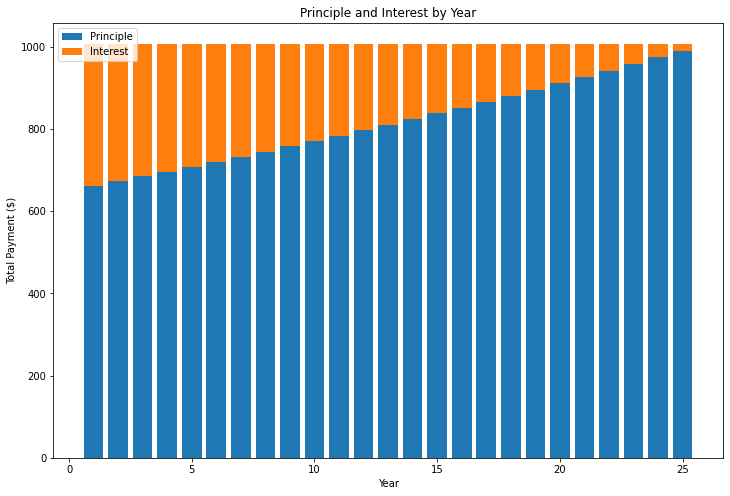

In [9]:
plt.figure(figsize=(12, 8))
p1 = plt.bar(payment_schedule_df['year'], payment_schedule_df['ppmt'])
p2 = plt.bar(payment_schedule_df['year'], payment_schedule_df['ipmt'], bottom=payment_schedule_df['ppmt'])

plt.ylabel('Total Payment ($)')
plt.xlabel('Year')
plt.title('Principle and Interest by Year')
plt.legend((p1[0], p2[0]), ('Principle', 'Interest'))



plt.show()

In [34]:
#prototyping with bokeh